В текущем проекте мы взяли датасет с платформы Kaggle с данными о клиентах мобильного оператора. В нем представлена информация: о личных данных клиента (есть партнер, иждивенцы, (не)пожилой), о технической возможности подключения к услугам, о подключенных услугах, срок подключения, типа договора/оплаты и отказался или нет клиент от продолжения договора.

Для начала нам нужно прочитать и посмотреть на данные, затем привести их к удобному для анализа виду. 

Далее приступим к поиску закономерностей и причин оттока, выявим наиболее стабильные категории клиентов и приносящие больше всего денег (сегментация пользователей, АBC-анализ).



# Чтение и преобразование файла

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from scipy import stats
# from scipy.stats import binom, norm

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
np.random.seed(42)
%matplotlib inline

In [81]:
df = pd.read_csv('../datasets/customer_churn.csv', delimiter=',', encoding='utf-8')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [82]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   str    
 1   gender            7043 non-null   str    
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   str    
 4   Dependents        7043 non-null   str    
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   str    
 7   MultipleLines     7043 non-null   str    
 8   InternetService   7043 non-null   str    
 9   OnlineSecurity    7043 non-null   str    
 10  OnlineBackup      7043 non-null   str    
 11  DeviceProtection  7043 non-null   str    
 12  TechSupport       7043 non-null   str    
 13  StreamingTV       7043 non-null   str    
 14  StreamingMovies   7043 non-null   str    
 15  Contract          7043 non-null   str    
 16  PaperlessBilling  7043 non-null   str    
 17  Paymen

In [83]:
# смотрим, какие можно привести к числовому формату или категории

for col in df.columns[1:]:
    if len(df[col].unique()) == 2:
        print(f'{col}:',* df[col].unique())


gender: Female Male
SeniorCitizen: 0 1
Partner: Yes No
Dependents: No Yes
PhoneService: No Yes
PaperlessBilling: Yes No
Churn: No Yes


In [84]:
# приводим к числовому формату, убрав пробелы для точного совпадения
mapping = {'Yes': 1, 'No': 0}
for col in ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']:
    df[col] = df[col].apply(lambda x: x.strip()).map(mapping)

df['TotalCharges'] = df['TotalCharges'].apply(lambda x: x.strip()).apply(lambda x: float(x) if x else 0.0)

In [85]:
# приводим к типу categories, чтобы экономить память
types = {i: 'category' for i in ['gender',
                                 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                                 'DeviceProtection', 'TechSupport', 'StreamingTV',
                                 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']}
df = df.astype(types)


In [86]:
print(*sorted(df['tenure'].unique())) # смотрим, какие у нас значения в столбце


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72


In [87]:
# разбиваем категории
df['tenure_groups'] = pd.cut(df['tenure'], 15)
df['MonthlyCharges_groups'] = pd.cut(df['MonthlyCharges'], 15)


In [88]:
# приводим категории к красивому виду
df['tenure_groups'] = df.groupby('tenure_groups')['tenure'] \
    .transform(lambda x: f"{int(x.min())}-{int(x.max())}")
df['tenure_groups'].unique()

<StringArray>
[  '0-4', '34-38', '44-48',   '5-9', '20-24', '10-14', '25-28', '58-62',
 '15-19', '49-52', '68-72', '29-33', '63-67', '39-43', '53-57']
Length: 15, dtype: str

In [89]:
# значения стали числовыми и потому при сортировке будут отображаться неверно. задаем им верный порядок
df['tenure_groups'] = df['tenure_groups'].replace({'5-9': '05-09'})
custom_order = ['0-4', '05-09', '10-14', '15-19', '20-24', '25-28', '29-33',
                '34-38', '39-43', '44-48', '49-52', '53-57', '58-62', '63-67', '68-72']

# Преобразование в категориальный тип с заданным порядком
df['tenure_groups'] = pd.Categorical(df['tenure_groups'], categories=custom_order, ordered=True)

# Теперь при группировке или value_counts() будет нужный порядок
print(df['tenure_groups'].value_counts().sort_index())

tenure_groups
0-4      1238
05-09     616
10-14     517
15-19     436
20-24     403
25-28     287
29-33     342
34-38     327
39-43     320
44-48     318
49-52     282
53-57     347
58-62     349
63-67     415
68-72     846
Name: count, dtype: int64


In [90]:
# приводим категории ежемесячных расходов к красивому виду
df['MonthlyCharges_groups'] = df.groupby('MonthlyCharges_groups')['MonthlyCharges'] \
    .transform(lambda x: f"{int(x.min())}-{int(x.max())}")
df['MonthlyCharges_groups'].unique()

<StringArray>
[  '25-31',   '51-58',   '38-45',   '65-71',  '98-105',   '85-91',   '45-51',
   '18-24', '105-111', '112-118',   '58-65',   '92-98',   '71-78',   '78-85',
   '33-38']
Length: 15, dtype: str

# Сегментация пользователей

## Делаем сводные таблицы для первого поиска закономерностей

In [91]:
# Смотрим комбинацию возраста и типа контракта
age_contract = pd.crosstab(
    [df['SeniorCitizen'], df['Contract']],
    df['Churn'],
    normalize='index'
) * 100

print("Отток по возрасту и типу контракта (%):")
print(age_contract[1].unstack().round(1))

Отток по возрасту и типу контракта (%):
Contract       Month-to-month  One year  Two year
SeniorCitizen                                    
0                        39.6      10.7       2.7
1                        54.6      15.3       4.1


In [92]:
age_payment = pd.crosstab(
    [df['SeniorCitizen'], df['PaymentMethod']],
    df['Churn'],
    normalize='index'
) * 100

print("\nОтток по возрасту и способу оплаты (%):")
print(age_payment[1].unstack().round(1))


Отток по возрасту и способу оплаты (%):
PaymentMethod  Bank transfer (automatic)  Credit card (automatic)  \
SeniorCitizen                                                       
0                                   15.6                     13.1   
1                                   22.7                     28.1   

PaymentMethod  Electronic check  Mailed check  
SeniorCitizen                                  
0                          42.6          17.4  
1                          53.4          46.8  


In [93]:
age_tenure = pd.crosstab(
    [df['SeniorCitizen'], df['tenure_groups']],
    df['Churn'],
    normalize='index'
) * 100

print("\nОтток по возрасту и длительности подписки (%):")
print(age_tenure[1].unstack().round(1))


Отток по возрасту и длительности подписки (%):
tenure_groups   0-4  05-09  10-14  15-19  20-24  25-28  29-33  34-38  39-43  \
SeniorCitizen                                                                 
0              51.3   36.2   30.4   26.2   20.6   15.3   19.6   16.4   16.8   
1              76.1   56.0   57.1   54.3   42.6   51.9   38.0   36.2   51.1   

tenure_groups  44-48  49-52  53-57  58-62  63-67  68-72  
SeniorCitizen                                            
0               11.3   11.9   13.3   10.0    8.6    4.1  
1               32.1   27.7   25.0   16.0   14.1    8.5  


In [94]:
# Какие услуги чаще/реже используют пожилые
services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'StreamingTV', 'StreamingMovies', 'PhoneService']

print("Процент подключения услуг по возрастным группам:")
for service in services:
    usage = pd.crosstab(
        df['SeniorCitizen'],
        df[service],
        normalize='index'
    ) * 100
    print(f"\n{service}:")
    print(usage.round(1))

Процент подключения услуг по возрастным группам:

OnlineSecurity:
OnlineSecurity    No  No internet service   Yes
SeniorCitizen                                  
0               45.6                 25.0  29.4
1               70.8                  4.6  24.7

OnlineBackup:
OnlineBackup     No  No internet service   Yes
SeniorCitizen                                 
0              41.9                 25.0  33.1
1              53.8                  4.6  41.7

DeviceProtection:
DeviceProtection    No  No internet service   Yes
SeniorCitizen                                    
0                 41.9                 25.0  33.1
1                 54.6                  4.6  40.8

TechSupport:
TechSupport      No  No internet service   Yes
SeniorCitizen                                 
0              44.8                 25.0  30.2
1              72.7                  4.6  22.8

StreamingTV:
StreamingTV      No  No internet service   Yes
SeniorCitizen                                 
0         

## Проверка и анализ подключенных услуг 

Мы видим, что график будет перегружен за счет поля 'no internet service', показатель которого везде одинаков. Нужно преобразовать данные так, чтобы они не влияли на подсчет долей.
Для начала проверим, правильно ли у нас указаны данные и 'no internet service' стоит одинаково во всех колонках с услугами и согласуется с информацией об интернет-сетях

In [95]:
service_check = df[['InternetService', 'OnlineSecurity', 'OnlineBackup',
                    'DeviceProtection', 'TechSupport', 'StreamingTV',
                    'StreamingMovies']].copy()
total = 0
for service in ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies']:

    # Находим строки, где InternetService='No' но услуга не 'No internet service'
    mask = (service_check['InternetService'] == 'No') & \
           (service_check[service] != 'No internet service')
    no_service = mask.sum()
    if no_service > 0:
        print(f"в сервисе {service} найдено {no_service} несоответствий")
    total += no_service
print(f"всего найдено {total} несоответствий")


всего найдено 0 несоответствий


Проверка показала, что если указано, что интернета нет, то и в остальных колонках по доп услугам это проставлено аналогично и корректно. Теперь можно в анализе оттока по доп услугам считать только тех людей, у кого есть интернет.
Сделаем визуализацию, чтобы понять, у какой услуги наибольшая разница в оттоке между подключившими и не подключившими услугу

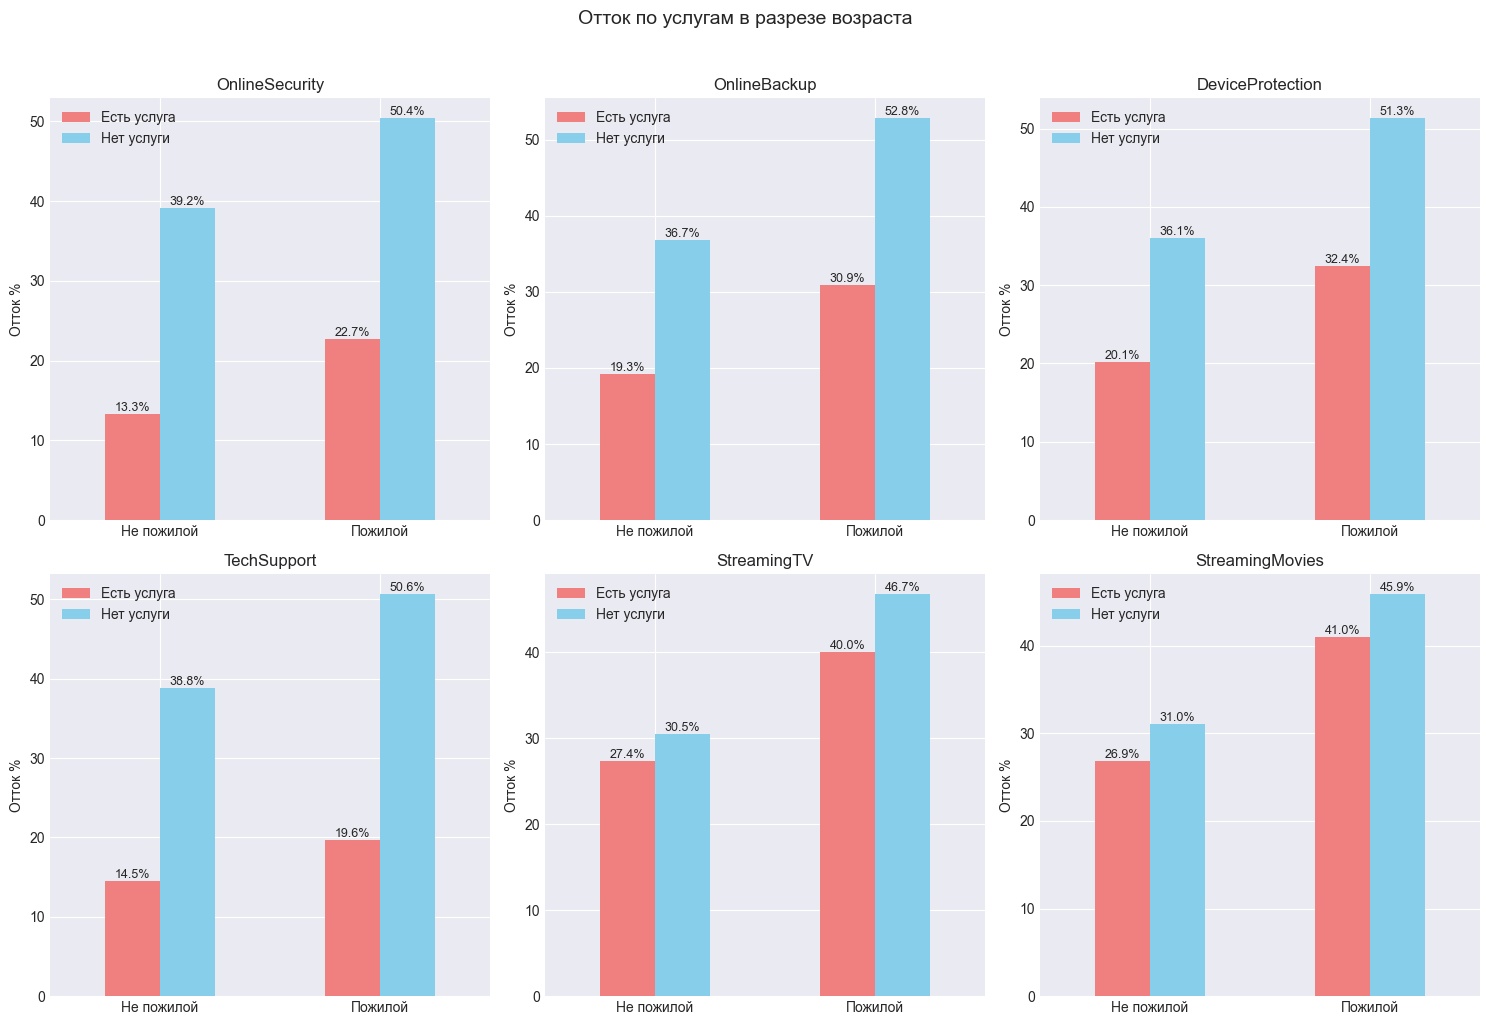

In [96]:
# для визуализации оставаляем только тех, у кого есть интернет
customers_with_internet = df[df['InternetService'] != 'No'].copy()

services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'StreamingTV', 'StreamingMovies']

# Подготовка данных для графика
plot_data = []
for service in services:
    for age in [0, 1]:
        for status in ['Yes', 'No']:
            mask = (customers_with_internet['SeniorCitizen'] == age) & \
                   (customers_with_internet[service] == status)
            churn_rate = customers_with_internet.loc[mask, 'Churn'].mean() * 100
            count = mask.sum()

            plot_data.append({
                'Услуга': service,
                'Возраст': 'Пожилой' if age else 'Не пожилой',
                'Статус': 'Есть услуга' if status == 'Yes' else 'Нет услуги',
                'Отток %': churn_rate,
                'Клиентов': count
            })

plot_df = pd.DataFrame(plot_data)

# Создаем графики
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, service in enumerate(services):
    ax = axes[idx]
    data = plot_df[plot_df['Услуга'] == service]

    # Группированная столбчатая диаграмма
    pivot_data = data.pivot(index='Возраст', columns='Статус', values='Отток %')
    pivot_data.plot(kind='bar', ax=ax, color=['lightcoral', 'skyblue'])

    ax.set_title(service, fontsize=12)
    ax.set_ylabel('Отток %')
    ax.set_xlabel('')
    ax.legend(title='')
    ax.tick_params(axis='x', rotation=0)

    # Добавляем значения на столбцы
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', fontsize=9)

plt.suptitle('Отток по услугам в разрезе возраста', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Для пожилых особенно важна тех.поддержка и безопасность -- подключение этих услуг существенно снижает процент оттока, а вот стриминговые фильмы и тв не являются для пользователей чем-то особенным, скорее всего конкуренты могут предложить аналогичные условия.

In [97]:
# Общая статистика
total_by_group = df.groupby('tenure_groups').size().rename('total')

# Ушедшие с PhoneService=1
churned_with_phone = (df[(df['Churn'] == 1) & (df['PhoneService'] == 1)]
                      .groupby('tenure_groups')
                      .size()
                      .rename('churned_with_phone'))

# Собираем все в один DataFrame
result = pd.DataFrame({
    'total': total_by_group,
    'churned_with_phone': churned_with_phone
}).fillna(0).astype(int)

# Добавляем проценты
result['%_of_group'] = (result['churned_with_phone'] / result['total'] * 100).round(1)
result['%_of_churned'] = (result['churned_with_phone'] / result['churned_with_phone'].sum() * 100).round(1)

print("\nСтатистика по tenure_groups для ушедших с PhoneService=1:")
print(result)


Статистика по tenure_groups для ушедших с PhoneService=1:
               total  churned_with_phone  %_of_group  %_of_churned
tenure_groups                                                     
0-4             1238                 605        48.9          35.6
05-09            616                 222        36.0          13.1
10-14            517                 161        31.1           9.5
15-19            436                 125        28.7           7.4
20-24            403                  90        22.3           5.3
25-28            287                  59        20.6           3.5
29-33            342                  75        21.9           4.4
34-38            327                  63        19.3           3.7
39-43            320                  60        18.8           3.5
44-48            318                  41        12.9           2.4
49-52            282                  38        13.5           2.2
53-57            347                  49        14.1           2.9
58-

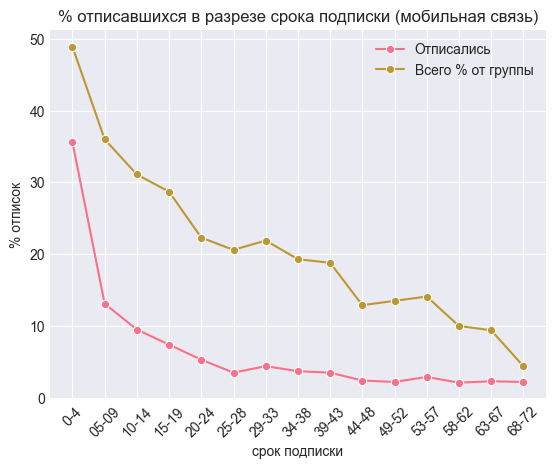

In [98]:
sns.lineplot(result, x='tenure_groups', y='%_of_churned', marker='o', label='Отписались')
sns.lineplot(result, x='tenure_groups', y='%_of_group', marker='o',label='Всего % от группы')
plt.title('% отписавшихся в разрезе срока подписки (мобильная связь)')
plt.legend()
plt.ylabel('% отписок')
plt.xlabel('срок подписки')
plt.xticks(rotation=45)
plt.show();

## Сравнение динамики поведения пользователей по возрасту

In [99]:
# Есть ли у пожилых партнеры/иждивенцы
family_senior = pd.crosstab(
    [df['SeniorCitizen'], df['Partner']],
    df['Churn'],
    normalize='index'
) * 100

print("Отток пожилых в зависимости от наличия партнера (%):")
print(family_senior[1].unstack().round(1))

# Проверяем иждивенцев
dependents_senior = pd.crosstab(
    [df['SeniorCitizen'], df['Dependents']],
    df['Churn'],
    normalize='index'
) * 100

print("\nОтток пожилых в зависимости от наличия иждивенцев (%):")
print(dependents_senior[1].unstack().round(1))

Отток пожилых в зависимости от наличия партнера (%):
Partner           0     1
SeniorCitizen            
0              30.0  16.6
1              48.9  34.6

Отток пожилых в зависимости от наличия иждивенцев (%):
Dependents        0     1
SeniorCitizen            
0              28.1  15.1
1              43.2  24.2


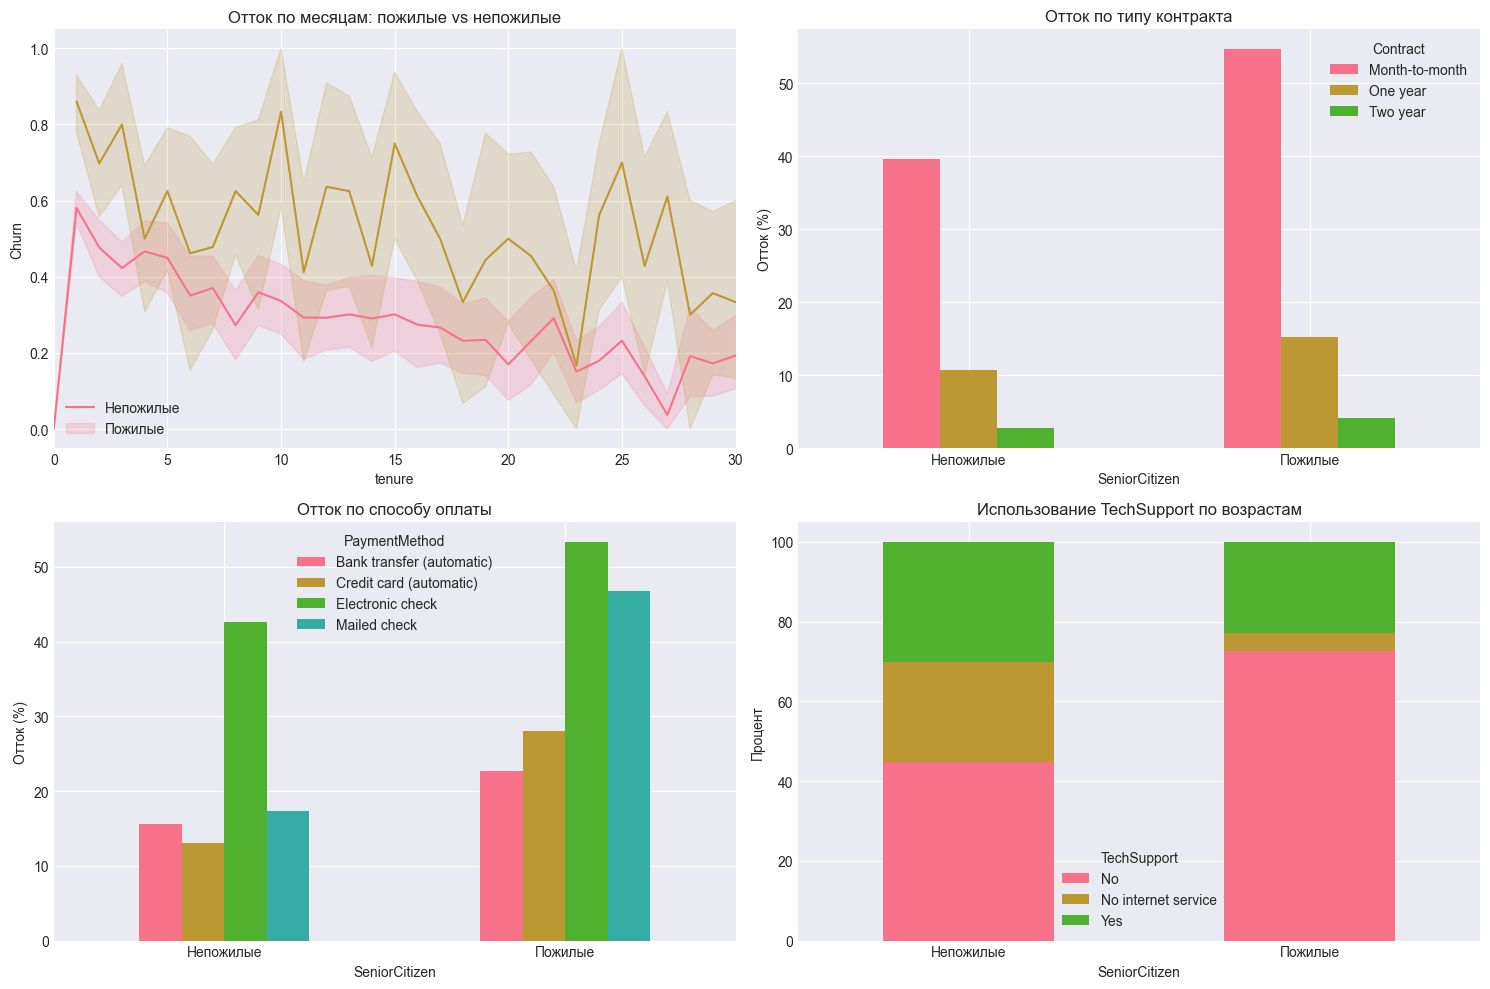

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Отток по месяцам для разных возрастов
sns.lineplot(data=df, x='tenure', y='Churn', hue='SeniorCitizen', ax=axes[0,0])
axes[0,0].set_title('Отток по месяцам: пожилые vs непожилые')
axes[0,0].set_xlim(0, 30)
axes[0,0].legend(['Непожилые', 'Пожилые'])

# Отток по типу контракта для разных возрастов
contract_churn = df.groupby(['SeniorCitizen', 'Contract'])['Churn'].mean().unstack() * 100
contract_churn.plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Отток по типу контракта')
axes[0,1].set_ylabel('Отток (%)')
axes[0,1].set_xticklabels(['Непожилые', 'Пожилые'], rotation=0)

# Отток по способу оплаты
payment_churn = df.groupby(['SeniorCitizen', 'PaymentMethod'])['Churn'].mean().unstack() * 100
payment_churn.plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Отток по способу оплаты')
axes[1,0].set_ylabel('Отток (%)')
axes[1,0].set_xticklabels(['Непожилые', 'Пожилые'], rotation=0)

# Распределение по услугам (TechSupport)
tech_by_age = pd.crosstab(df['SeniorCitizen'], df['TechSupport'], normalize='index') * 100
tech_by_age.plot(kind='bar', stacked=True, ax=axes[1,1])
axes[1,1].set_title('Использование TechSupport по возрастам')
axes[1,1].set_ylabel('Процент')
axes[1,1].set_xticklabels(['Непожилые', 'Пожилые'], rotation=0)
axes[1,1].legend(title='TechSupport')

plt.tight_layout()
plt.show()

In [101]:
df1 = df[['tenure_groups', 'MonthlyCharges_groups', 'SeniorCitizen', 'PaymentMethod', 'Contract', 'gender', 'Churn']]\
    .rename(columns={
    'tenure_groups': 'срок_подписки', 'MonthlyCharges_groups': 'ежемес.платеж',
    'SeniorCitizen': 'пожилые', 'PaymentMethod': 'способ_оплаты',
    'Contract': 'срок_договора', 'gender': 'пол', 'Churn': 'отток'
})
df1

,срок_подписки,ежемес.платеж,пожилые,способ_оплаты,срок_договора,пол,отток
0,0-4,25-31,0,Electronic check,Month-to-month,Female,0
1,34-38,51-58,0,Mailed check,One year,Male,0
2,0-4,51-58,0,Mailed check,Month-to-month,Male,1
3,44-48,38-45,0,Bank transfer (automatic),One year,Male,0
4,0-4,65-71,0,Electronic check,Month-to-month,Female,1
...,...,...,...,...,...,...,...
7038,20-24,78-85,0,Mailed check,One year,Male,0
7039,68-72,98-105,0,Credit card (automatic),One year,Female,0
7040,10-14,25-31,0,Electronic check,Month-to-month,Female,0
7041,0-4,71-78,1,Mailed check,Month-to-month,Male,1


## Анализируем, на каком сроке и каком типе договора чаще всего отписываются

In [102]:
# Создаем сводную таблицу, чтобы выявить, на каком сроке чаще всего отписываются
pivot = pd.pivot_table(
    df1,
    values='отток',
    index='срок_подписки',
    aggfunc=['sum', 'count', lambda x: (x.sum() / len(x) * 100).round(2)]
)

# Переименовываем колонки для понятности
pivot.columns = ['сумма_оттока', 'всего_подписок', 'доля_оттока_%']
print(pivot)

               сумма_оттока  всего_подписок  доля_оттока_%
срок_подписки                                             
0-4                     680            1238          54.93
05-09                   243             616          39.45
10-14                   176             517          34.04
15-19                   134             436          30.73
20-24                    98             403          24.32
25-28                    63             287          21.95
29-33                    80             342          23.39
34-38                    65             327          19.88
39-43                    70             320          21.88
44-48                    47             318          14.78
49-52                    41             282          14.54
53-57                    54             347          15.56
58-62                    38             349          10.89
63-67                    40             415           9.64
68-72                    40             846           4.

In [103]:
# Создаем сводную таблицу в разрезе способов оплаты
pivot2 = pd.pivot_table(
    df1,
    values='отток',
    index='способ_оплаты',
    aggfunc=['sum', 'count', lambda x: (x.sum() / len(x) * 100).round(2)]
)

# Переименовываем колонки для понятности
pivot2.columns = ['сумма_оттока', 'всего_подписок', 'доля_оттока_%']
print(pivot2)

                           сумма_оттока  всего_подписок  доля_оттока_%
способ_оплаты                                                         
Bank transfer (automatic)           258            1544          16.71
Credit card (automatic)             232            1522          15.24
Electronic check                   1071            2365          45.29
Mailed check                        308            1612          19.11


In [104]:
# Создаем сводную таблицу в разрезе типа продления договора
pivot3 = pd.pivot_table(
    df1,
    values='отток',
    index='срок_договора',
    aggfunc=['sum', 'count', lambda x: (x.sum() / len(x) * 100).round(2)]
)

# Переименовываем колонки для понятности
pivot3.columns = ['сумма_оттока', 'всего_подписок', 'доля_оттока_%']
print(pivot3)

                сумма_оттока  всего_подписок  доля_оттока_%
срок_договора                                              
Month-to-month          1655            3875          42.71
One year                 166            1473          11.27
Two year                  48            1695           2.83


In [105]:
# Создаем сводную таблицу в разрезе возраста
pivot4 = pd.pivot_table(
    df1,
    values='отток',
    index='пожилые',
    aggfunc=['sum', 'count', lambda x: (x.sum() / len(x) * 100).round(2)]
)

# Переименовываем колонки для понятности
pivot4.columns = ['сумма_оттока', 'всего_подписок', 'доля_оттока_%']
print(pivot4)

         сумма_оттока  всего_подписок  доля_оттока_%
пожилые                                             
0                1393            5901          23.61
1                 476            1142          41.68


# ABC-анализ и сегментация пользователей в разрезе LTV.

## Подготовим данные

In [106]:
# Выделим столбцы с id клиента и суммой, потораченной каждым клиентом
df_abc = df[['customerID', 'TotalCharges']].copy()
df_abc.head()

,customerID,TotalCharges
0,7590-VHVEG,29.85
1,5575-GNVDE,1889.50
2,3668-QPYBK,108.15
3,7795-CFOCW,1840.75
4,9237-HQITU,151.65


In [107]:
# сортируем total charges по убыванию
df_abc = df_abc.sort_values('TotalCharges', ascending=False).reset_index(drop=True)
# посчитаем общую выручку компании, долю каждого клиента от общей выручки
total_revenue = df_abc['TotalCharges'].sum()
df_abc['revenue_share'] = df_abc['TotalCharges'] / total_revenue * 100
#  считаем накопленную долю каждого клиента
df_abc['cumulative_share'] = df_abc['revenue_share'].cumsum()

df_abc.head()

,customerID,TotalCharges,revenue_share,cumulative_share
0,2889-FPWRM,8684.80,0.054090,0.054090
1,7569-NMZYQ,8672.45,0.054013,0.108103
2,9739-JLPQJ,8670.10,0.053999,0.162102
3,9788-HNGUT,8594.40,0.053527,0.215629
4,8879-XUAHX,8564.75,0.053342,0.268971


In [108]:
# теперь нужно присвоить категорию АВС: А = 0-80%, В = 80-95%, С = 95-100%
def assign_abc_mark(cumulative_sum):
    return 'A' if cumulative_sum <= 80 else ('B' if cumulative_sum <= 95 else 'C')

df_abc['abc_mark'] = df_abc['cumulative_share'].apply(assign_abc_mark)

# Проверим распределение
print(df_abc['abc_mark'].value_counts())

abc_mark
A    2701
C    2649
B    1693
Name: count, dtype: int64


## Визуализируем кривую Паретто

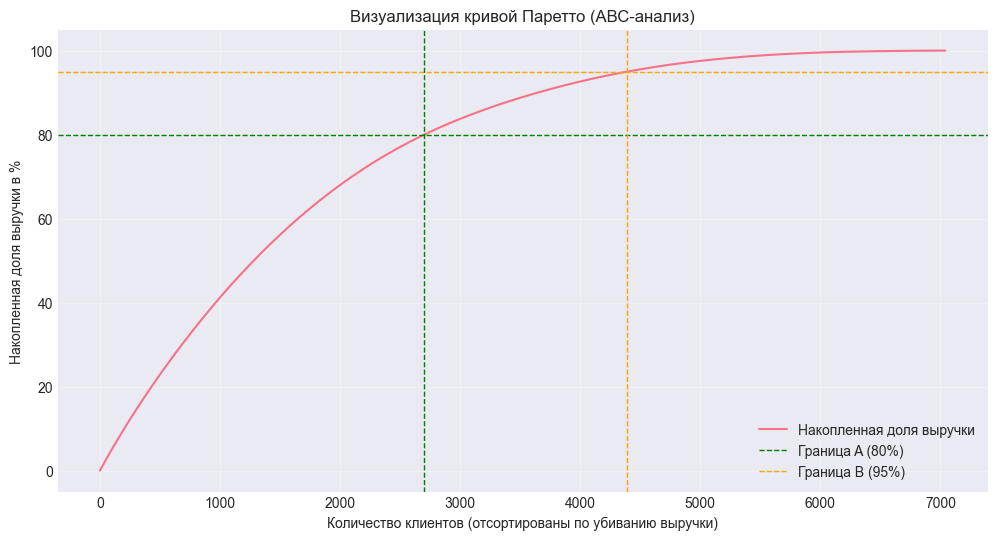

In [109]:
plt.figure(figsize=(12,6))
plt.plot(df_abc.index, df_abc['cumulative_share'], label='Накопленная доля выручки')
# Добавляем горизонтальные и вертикальные линии для границ A, B, C
plt.axhline(y=80, color='green', linestyle='--', linewidth=1, label='Граница A (80%)')
plt.axhline(y=95, color='orange', linestyle='--', linewidth=1, label='Граница B (95%)')

# Находим примерные границы по оси X (количество клиентов)
limit_a = df_abc[df_abc['cumulative_share'] <= 80].index.max()
limit_b = df_abc[df_abc['cumulative_share'] <= 95].index.max()

plt.axvline(x=limit_a, color='green', linestyle='--', linewidth=1)
plt.axvline(x=limit_b, color='orange', linestyle='--', linewidth=1)

plt.xlabel('Количество клиентов (отсортированы по убиванию выручки)')
plt.ylabel('Накопленная доля выручки в %')
plt.title('Визуализация кривой Паретто (АВС-анализ)')

plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [110]:
# теперь посмотрим на цифры, сколько клиентов составляют кажду группу и какой процент выручки
group_stats = df_abc.groupby('abc_mark').agg(
    total_revenue = ('TotalCharges', 'sum'),
    customer_count = ('customerID', 'count')
).reset_index()
# теперь посчитаем доли на соответствие закону Паретто
group_stats['revenue_share_%'] = round(group_stats['total_revenue'] / group_stats['total_revenue'].sum()*100, 2)
group_stats['customer_share_%'] = round(group_stats['customer_count'] / group_stats['customer_count'].sum() * 100,2)

group_stats


,abc_mark,total_revenue,customer_count,revenue_share_%,customer_share_%
0,A,12843549.90,2701,79.99,38.35
1,B,2409543.15,1693,15.01,24.04
2,C,803075.65,2649,5.00,37.61


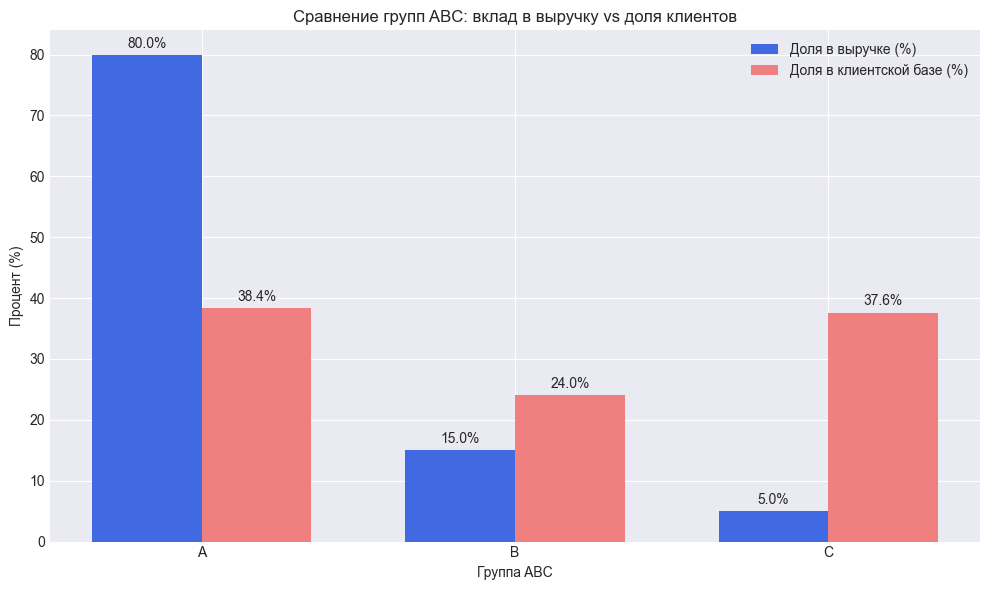

In [111]:
# Строим двойную столбчатую диаграмму
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(group_stats['abc_mark']))
width = 0.35

# Столбцы для доли выручки и доли клиентов
bars1 = ax.bar(x - width/2, group_stats['revenue_share_%'], width, label='Доля в выручке (%)', color='royalblue')
bars2 = ax.bar(x + width/2, group_stats['customer_share_%'], width, label='Доля в клиентской базе (%)', color='lightcoral')

# Добавляем подписи
ax.set_xlabel('Группа ABC')
ax.set_ylabel('Процент (%)')
ax.set_title('Сравнение групп ABC: вклад в выручку vs доля клиентов')
ax.set_xticks(x)
ax.set_xticklabels(group_stats['abc_mark'])
ax.legend()
ax.bar_label(bars1, padding=3, fmt='%.1f%%')
ax.bar_label(bars2, padding=3, fmt='%.1f%%')

plt.tight_layout()
plt.show()

In [112]:
df = df.merge(df_abc[['customerID', 'abc_mark']], how='left', on='customerID')

churn_by_abc = df.groupby('abc_mark')['Churn'].agg(['sum', 'mean', 'count'])
churn_by_abc['mean'] = churn_by_abc['mean'] * 100

print("Отток по группам ABC:")
print(churn_by_abc.round(2))

Отток по группам ABC:
           sum   mean  count
abc_mark                    
A          492  18.22   2701
B          374  22.09   1693
C         1003  37.86   2649


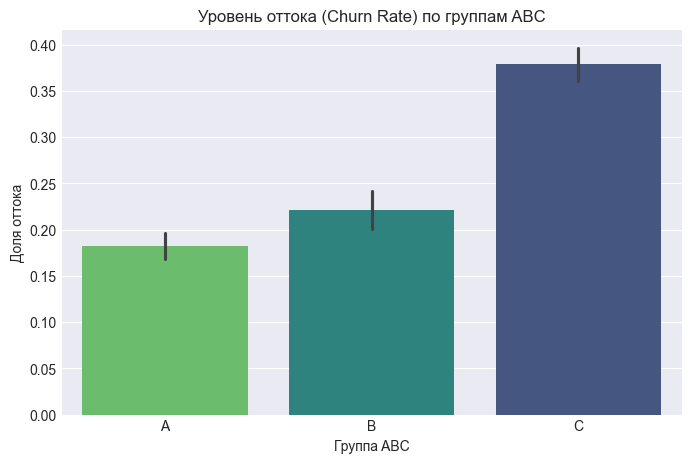

In [113]:
# Визуализируем отток
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='abc_mark', y='Churn', order=['A', 'B', 'C'], hue='abc_mark', palette='viridis')
plt.title('Уровень оттока (Churn Rate) по группам ABC')
plt.ylabel('Доля оттока')
plt.xlabel('Группа ABC')
plt.show()

## Интерпретация результата
Группа А, приносящая 80% прибыли компании и составляющая ~ 40% ее аудитории -- наиболее устойчива к оттоку, доля оттока менее 20%

# Комбинированная сегментация

Ранее мы разделили пользователей на группы исходя из общей потраченной на услуги суммы. Однако, ежемесячный вклад может отличаться. Так, если пользователь оплачивает дешевый тарифный план, он может быть постоянным клиентом на протяжении многих лет, но при этом приносить денег компании меньше, чем пользователь, присоединившийся не так давно, но потребляющий больше услуг и приносящий больше денег ежемесячно.

Проверим эту гипотезу.


## Сегментация по ARPU (MonthlyCharges) + tenure
Делим клиентов на 3 группы по среднемесячному платежу и на 3 группы по сроку подписки. Получаем матрицу 3×3.

In [114]:
df_charges = df[['customerID', 'tenure', 'MonthlyCharges', 'Churn', 'TotalCharges', 'abc_mark']].copy()
df_charges['ARPU_group'] = pd.qcut(df_charges['MonthlyCharges'], q=3, labels=['low_ARPU', 'medium_ARPU', 'high_ARPU'])
df_charges['tenure_group'] = pd.qcut(df_charges['tenure'], q=3, labels=['new', 'medium', 'old'])


pivot_table = pd.crosstab(
    [df_charges['ARPU_group'], df_charges['tenure_group']],
    df_charges['Churn'],
    normalize='index'
)*100
print("Отток в разрезе ARPU и стажа:")
print(pivot_table.round(1))

Отток в разрезе ARPU и стажа:
Churn                        0     1
ARPU_group  tenure_group            
low_ARPU    new           70.4  29.6
            medium        92.5   7.5
            old           97.2   2.8
medium_ARPU new           47.9  52.1
            medium        78.1  21.9
            old           94.3   5.7
high_ARPU   new           26.2  73.8
            medium        60.8  39.2
            old           84.7  15.3


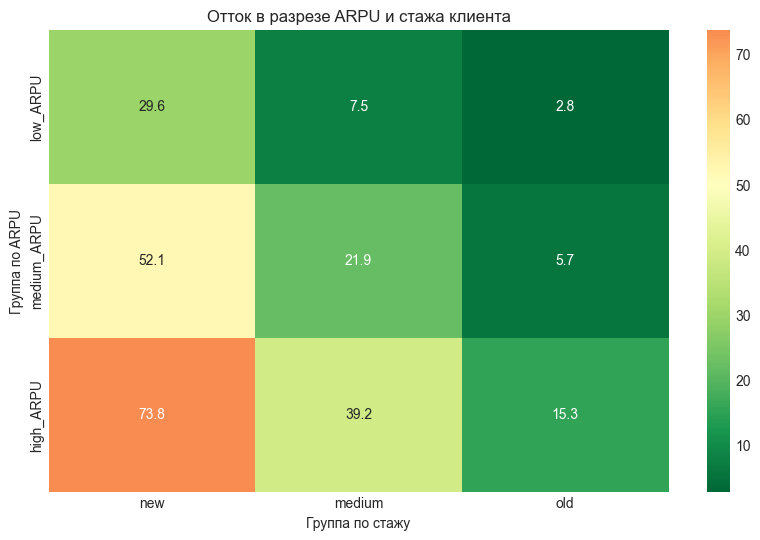

In [115]:
plt.figure(figsize=(10, 6))
pivot_unstack = pivot_table[1].unstack()  # Берем только отток
sns.heatmap(pivot_unstack, annot=True, fmt='.1f', cmap='RdYlGn_r', center=50)
plt.title('Отток в разрезе ARPU и стажа клиента')
plt.ylabel('Группа по ARPU')
plt.xlabel('Группа по стажу')
plt.show()

In [116]:
# Создаем метрику, которая показывает, насколько сильно клиент "тратится" относительно среднего по своей когорте.

# Считаем средний MonthlyCharges для каждой группы по стажу
avg_by_tenure = df_charges.groupby('tenure_group')['MonthlyCharges'].transform('mean')

# Создаем индекс: платит ли клиент выше или ниже среднего для своего стажа
df_charges['spending_index'] = df_charges['MonthlyCharges'] / avg_by_tenure

# Теперь можно сегментировать по этому индексу
df_charges['spending_category'] = pd.cut(
    df_charges['spending_index'],
    bins=[0, 0.8, 1.2, float('inf')],
    labels=['Ниже среднего', 'Средний', 'Выше среднего']
)

# Анализируем отток
spending_analysis = df_charges.groupby('spending_category')['Churn'].agg(['mean', 'count'])
spending_analysis['mean'] = spending_analysis['mean'] * 100
print(spending_analysis.round(1))

                   mean  count
spending_category             
Ниже среднего      13.3   2298
Средний            18.8   1689
Выше среднего      40.8   3056


## ABC в разрезе ARPU

In [117]:
df_charges.head()

,customerID,tenure,MonthlyCharges,Churn,TotalCharges,abc_mark,ARPU_group,tenure_group,spending_index,spending_category
0,7590-VHVEG,1,29.85,0,29.85,C,low_ARPU,new,0.528403,Ниже среднего
1,5575-GNVDE,34,56.95,0,1889.50,B,medium_ARPU,medium,0.884713,Средний
2,3668-QPYBK,2,53.85,1,108.15,C,medium_ARPU,new,0.953250,Средний
3,7795-CFOCW,45,42.30,0,1840.75,B,low_ARPU,medium,0.657126,Ниже среднего
4,9237-HQITU,2,70.70,1,151.65,C,medium_ARPU,new,1.251528,Выше среднего


In [118]:
df_charges = df_charges.sort_values(by='MonthlyCharges', ascending=False)
df_charges['cumulative_sum'] = df_charges.MonthlyCharges.cumsum()
df_charges['cumulative_share'] = df_charges['cumulative_sum'] / df_charges['MonthlyCharges'].sum()*100
df_charges['abc_mark_monthly'] = df_charges['cumulative_share'].apply(assign_abc_mark)

df_charges.head()

,customerID,tenure,MonthlyCharges,Churn,TotalCharges,abc_mark,ARPU_group,tenure_group,spending_index,spending_category,cumulative_sum,cumulative_share,abc_mark_monthly
4586,7569-NMZYQ,72,118.75,0,8672.45,A,high_ARPU,old,1.611736,Выше среднего,118.75,0.026035,A
2115,8984-HPEMB,71,118.65,0,8477.60,A,high_ARPU,old,1.610378,Выше среднего,237.40,0.052048,A
4804,5734-EJKXG,61,118.60,0,7365.70,A,high_ARPU,old,1.609700,Выше среднего,356.00,0.078050,A
3894,5989-AXPUC,68,118.60,0,7990.05,A,high_ARPU,old,1.609700,Выше среднего,474.60,0.104052,A
5127,8199-ZLLSA,67,118.35,1,7804.15,A,high_ARPU,old,1.606307,Выше среднего,592.95,0.130000,A


In [123]:
df_charges.abc_mark_monthly.value_counts()

abc_mark_monthly
A    4224
B    1674
C    1145
Name: count, dtype: int64

In [133]:
cross_marks = pd.crosstab(df_charges['abc_mark'], df_charges['abc_mark_monthly']
                          )
print("Пересечение категорий (Monthly vs Total), кол-во пользователей:\n")
print(cross_marks)

Пересечение категорий (Monthly vs Total), кол-во пользователей:

abc_mark_monthly     A    B    C
abc_mark                        
A                 2480  221    0
B                  785  601  307
C                  959  852  838


In [131]:
# Анализ оттока в каждой комбинации АВС ежемесячных трат и АВС-тотал
churn_by_combination = df_charges.groupby(['abc_mark_monthly','abc_mark'])['Churn'].mean() * 100
print("\nОтток по комбинациям:")
print(churn_by_combination.round(1))


Отток по комбинациям:
abc_mark_monthly  abc_mark
A                 A           19.0
                  B           40.1
                  C           62.9
B                 A            9.0
                  B            9.0
                  C           36.2
C                 B            1.6
                  C           11.0
Name: Churn, dtype: float64


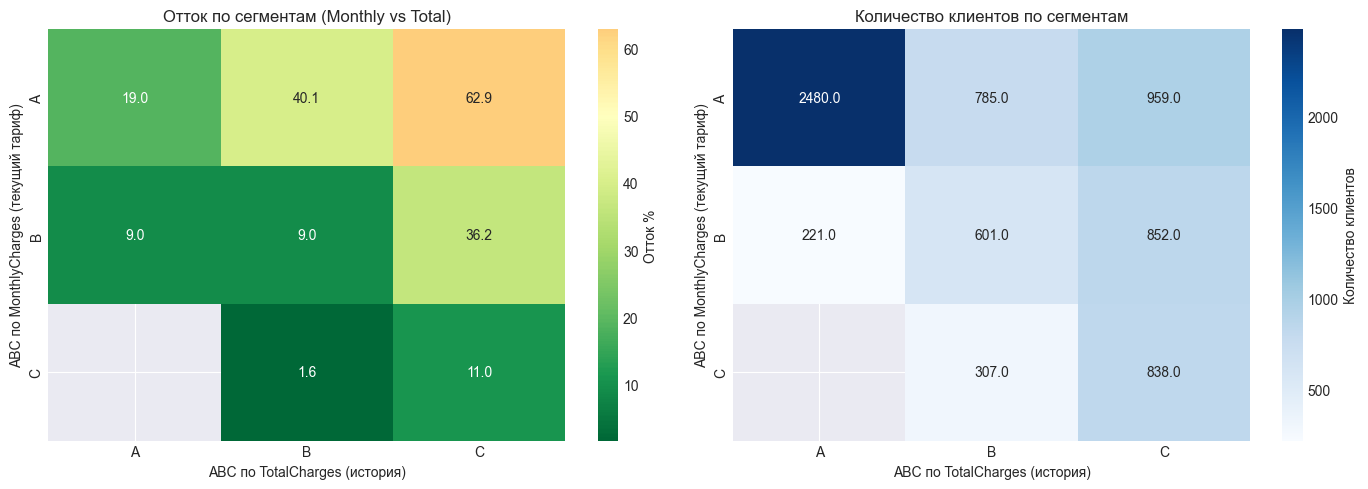

In [141]:
pivot_churn = pd.pivot_table(data=df_charges, index='abc_mark_monthly',
                       columns='abc_mark', values='Churn', aggfunc='mean') * 100

pivot_count = pd.pivot_table(data=df_charges, index='abc_mark_monthly',
                       columns='abc_mark', values='Churn', aggfunc='count')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
# Тепловая карта оттока
sns.heatmap(pivot_churn, annot=True, fmt='.1f', cmap='RdYlGn_r',
            center=50, ax=ax1, cbar_kws={'label': 'Отток %'})
ax1.set_title('Отток по сегментам (Monthly vs Total)')
ax1.set_xlabel('ABC по TotalCharges (история)')
ax1.set_ylabel('ABC по MonthlyCharges (текущий тариф)')

# Тепловая карта количества клиентов
sns.heatmap(pivot_count, annot=True, fmt='.1f', cmap='Blues', ax=ax2,
            cbar_kws={'label': 'Количество клиентов'})
ax2.set_title('Количество клиентов по сегментам')
ax2.set_xlabel('ABC по TotalCharges (история)')
ax2.set_ylabel('ABC по MonthlyCharges (текущий тариф)')

plt.tight_layout()
plt.show()